Process data: import follium tree, trunk outline surface, computing interaction between them.

In [1]:
import h5py
from copy import copy
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import networkx as nx

In [2]:
from genepy3d.obj import curves, trees, points, surfaces
from genepy3d.io import swc
from genepy3d_gpl.interact import curvesurface
from genepy3d.util import plot as myplt, geo

In [4]:
%matplotlib notebook

In [ ]:
# import importlib
# importlib.reload(trees);
# importlib.reload(curves);
# importlib.reload(points);
# importlib.reload(surfaces);
# importlib.reload(curvesurface);

# Importing Follium filaments

The Follium filaments were traced in Imaris and exported in .ims, trying to exploit the data structure and import to GeNePy3D Tree object.

## Function

In [9]:
def from_ims(file):
    """Import Tree from .ims
    
    Args:
        file (str): file path
        
    Returns:
        Tree
        
    """
    # read file
    f = h5py.File(file,"r")
    
    # import vertex
    item = f["Scene8"]["Content"]["Filaments0"]["Vertex"]
    item_arr = np.array([item[i].tolist() for i in range(len(item))])
    vertex = pd.DataFrame(item_arr,columns=["x","y","z","r"])
    
    # import edge
    item = f["Scene8"]["Content"]["Filaments0"]["Edge"]
    item_arr = np.array([item[i].tolist() for i in range(len(item))])
    edge = pd.DataFrame(item_arr,columns=["vertex_begin","vertex_end"])
    
    # build graph from vertices and edges
    G=nx.Graph()
    G.add_nodes_from(vertex.index.tolist())
    G.add_edges_from(edge.values.tolist())
    
    # import dendrite table
    item = f["Scene8"]["Content"]["Filaments0"]["DendriteSegment"]
    item_arr = np.array([item[i].tolist() for i in range(len(item))])
    dendrite = pd.DataFrame(item_arr,columns=["id_time","id","vertex_begin","vertex_end","edge_begin","edge_end"])
    
    # import dendrite edge index table
    item = f["Scene8"]["Content"]["Filaments0"]["DendriteSegmentEdge"]
    item_arr = np.array([item[i].tolist() for i in range(len(item))])
    dendrite_edge = pd.DataFrame(item_arr,columns=["index"])
    
    # import dendrite vertex index table
    item = f["Scene8"]["Content"]["Filaments0"]["DendriteSegmentVertex"]
    item_arr = np.array([item[i].tolist() for i in range(len(item))])
    dendrite_vertex = pd.DataFrame(item_arr,columns=["index"])
    
    # compute dendrite fragments
    parent = {}
    big_vertex_lst = []

    for ix in range(len(dendrite)):

        subdf = dendrite.iloc[ix]

        # get IDs of edge begin and pair of vertices making the edge begin
        vertex_begin = dendrite_vertex.loc[subdf["vertex_begin"]][0] # get vertex begin
        edge_begin = dendrite_edge.loc[subdf["edge_begin"]].values[0] # get edge begin
        vertices_begin = edge.loc[edge_begin].values # get pair of vertices making the edge begin
        vertex_begin_partner = np.setdiff1d(vertices_begin,vertex_begin)[0] # get the second vertex from the pair

        # get IDs of edge end and pair of vertices making the edge end
        vertex_end = dendrite_vertex.loc[subdf["vertex_end"]-1][0]
        edge_end = dendrite_edge.loc[subdf["edge_end"]-1].values[0]
        vertices_end = edge.loc[edge_end].values
        vertex_end_partner = np.setdiff1d(vertices_end,vertex_end)[0]

        # check all path starting from vertex begin to vertex end
        # then get only path containing both edge begin and edge end
        vertex_lst = []
        for path in nx.all_simple_paths(G, source=vertex_begin, target=vertex_end):
            if (vertex_begin_partner == path[1]) & (vertex_end_partner == path[-2]):
                vertex_lst = path

        # create parent-children link
        if len(vertex_lst)!=0:
            for i in range(1,len(vertex_lst)):
                child_vertex = vertex_lst[i]
                parent_vertex = vertex_lst[i-1]
                parent[child_vertex] = parent_vertex

        big_vertex_lst += vertex_lst
    
    # build dendritic dataframe
    big_vertex_lst = np.unique(big_vertex_lst)
    
    parent_vertex_lst = []
    for key in big_vertex_lst:
        if key in parent.keys():
            parent_vertex_lst.append(parent[key])
        else:
            parent_vertex_lst.append(-1)
            
    df = vertex.loc[big_vertex_lst].copy()
    df["treenode_id"] = big_vertex_lst
    df["parent_treenode_id"] = parent_vertex_lst
    df["structure_id"] = 0
    
    return (trees.Tree.from_table(df),df)

## DIV4 Follium

In [10]:
f = "data/DIV4/2020_06_28_DIV4-Folium2-23h016.ims"
foli4, df4 = from_ims(f)

## DIV6 Follium

In [11]:
f = "data/DIV6/2020_06_15_DIV6-Folium2-15h.ims"
foli6, df6 = from_ims(f)

# Importing Trunk outline surface

Trunk outlines were drawn in Imaris and exported in .wrl format, we then use MeshLab to simplify and export the surface to .stl for importing to GeNePy3D.

Steps to compute the convex hull of the trunk outline in Meshlab: 
- import .wrt
- simplification to 2000 faces
- get convex hull

## DIV4

In [12]:
file = "data/DIV4/trunk4_meshlab_hull.stl"
trunk4 = surfaces.Surface.from_STL(file)

In [13]:
print("closed surface ?",trunk4.is_watertight)
print("nb. of faces:",trunk4.faces.shape[0])
print("nb. of vertices:",trunk4.vertices.shape[0])
print("area:",trunk4.area)
print("volume:",trunk4.volume)

closed surface ? True
nb. of faces: 142
nb. of vertices: 73
area: 189921.64922001614
volume: 2551283.3852614705


In [14]:
_, v4, _ = trunk4.to_points().pca()
mean4 = np.mean(trunk4.to_points().coors,axis=0)

## DIV6

In [ ]:
file = "data/DIV6/trunk6_meshlab_hull.stl"
trunk6 = surfaces.Surface.from_STL(file)

In [ ]:
print("closed surface ?",trunk6.is_watertight)
print("nb. of faces:",trunk6.faces.shape[0])
print("nb. of vertices:",trunk6.vertices.shape[0])
print("area:",trunk6.area)
print("volume:",trunk6.volume)

closed surface ? True
nb. of faces: 146
nb. of vertices: 75
area: 107908.84765882687
volume: 1250256.3439134883


In [ ]:
_, v6, _ = trunk6.to_points().pca()
mean6 = np.mean(trunk6.to_points().coors,axis=0)

# Measure traces morphology relative to the trunk outline

### Initializing columns for dataframe

In [15]:
# initialize dataframe columns
folliums, filaments = [], []
lengths, tortuosities = [], []

radius = 35 # micron
ls = [] # local 3d scale

xints, yints, zints = [], [], []
xthetas, ythetas, zthetas = [], [], []
f1thetas, f2thetas = [], [] # angle w.r.t. follium orientation

### DIV4: measuring and plotting

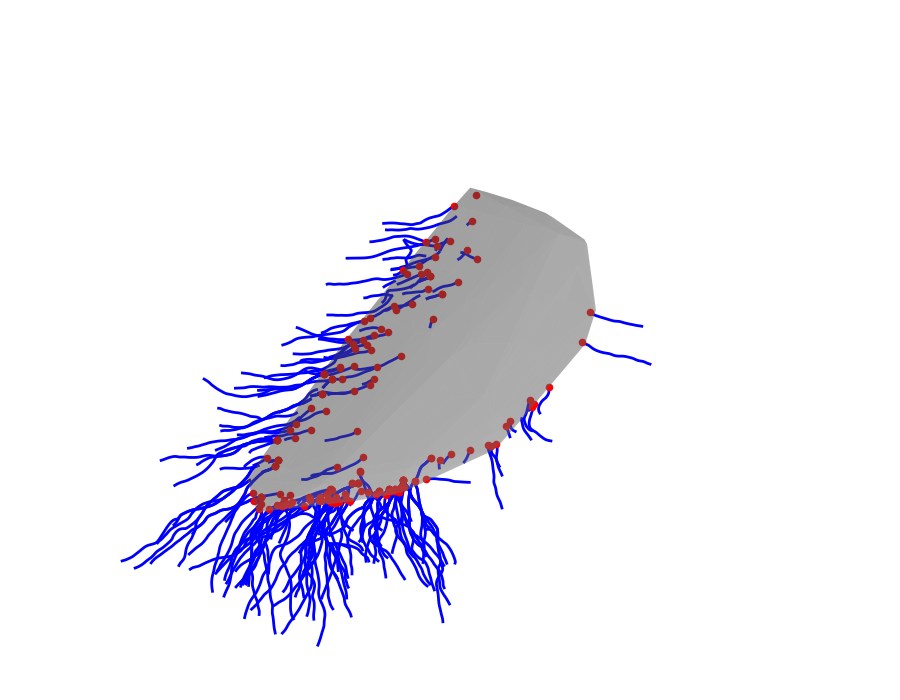

In [16]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111,projection="3d")

filament_id = 0

rootid_lst = foli4.get_root()
for i in range(len(rootid_lst)):
    rootid = rootid_lst[i]
    
    # extract filament from rootid
    filament = foli4.extract_subtrees(nodeid=rootid,rootid=rootid)
    
#     foli4.plot(ax,rootid=rootid,projection="3d",
#                show_root=True,root_args={"s":25},
#                show_branchingnodes=False,show_leaves=False)
    
    # checking intersection
    for nodes in filament.decompose_leaves().values():
        
        length, tortuosity, lstmp = 0,[],[]
        xtheta, ytheta, ztheta = [],[],[]
        f1theta, f2theta = [], []
        
        # convert to Curve
        crv = filament.to_curve(nodes)
        intersect_pnts, _ = curvesurface.intersect(crv,trunk4)
        if intersect_pnts is not None:
            # intersected points
            xint, yint, zint = intersect_pnts.coors[0,0],intersect_pnts.coors[0,1],intersect_pnts.coors[0,2]
            ax.scatter(xint,yint,zint,color="red")
            
            # getting section from outside of the trunk
            _, _, outside_sections = curvesurface.inonout(crv,trunk4)
            if len(outside_sections)!=0:
                for s in outside_sections:
                    s.plot(ax, projection="3d", show_root=False, line_args={'c':'blue','lw':2})
                    
                    length += s.compute_length()
                    
                    tortuosity.append(s.compute_tortuosity())
                    
                    lstmp.append(np.mean(s.compute_local_3d_scale(np.arange(1,radius+1,1))))
                    
                    _, thetas = s.compute_orientation()
                    xtheta += list(thetas[:,0])
                    ytheta += list(thetas[:,1])
                    ztheta += list(thetas[:,2])
                    
                    _, tmp = s.compute_orientation(u=np.array([v4[0,0],v4[0,1],0])) # angle with the first pca
                    f1theta += list(tmp)
                    
                    _, tmp = s.compute_orientation(u=np.array([v4[1,0],v4[1,1],0])) # angle with the second pca
                    f2theta += list(tmp)  
                    
        if((length!=0) & (len(tortuosity)!=0) & (len(lstmp)!=0)):
            xints.append(xint)
            yints.append(yint)
            zints.append(zint)
            lengths.append(length)
            tortuosities.append(np.mean(tortuosity))
            ls.append(np.mean(lstmp))
            xthetas.append(np.mean(xtheta)*180/np.pi)
            ythetas.append(np.mean(ytheta)*180/np.pi)
            zthetas.append(np.mean(ztheta)*180/np.pi)
            f1thetas.append(np.mean(f1theta)*180/np.pi)
            f2thetas.append(np.mean(f2theta)*180/np.pi)
            folliums.append("DIV4")
            filaments.append(filament_id)
            filament_id += 1
                    
trunk4.plot(ax,projection="3d",args_3d={"edgecolor":None,"alpha":0.3,"color":"gray"})
ax.view_init(azim=75,elev=-120)
ax.axis("off");

plt.tight_layout();

In [13]:
fig.savefig("output/div4-intersection.png",dpi=400)

### DIV6: measuring and plotting

<IPython.core.display.Javascript object>


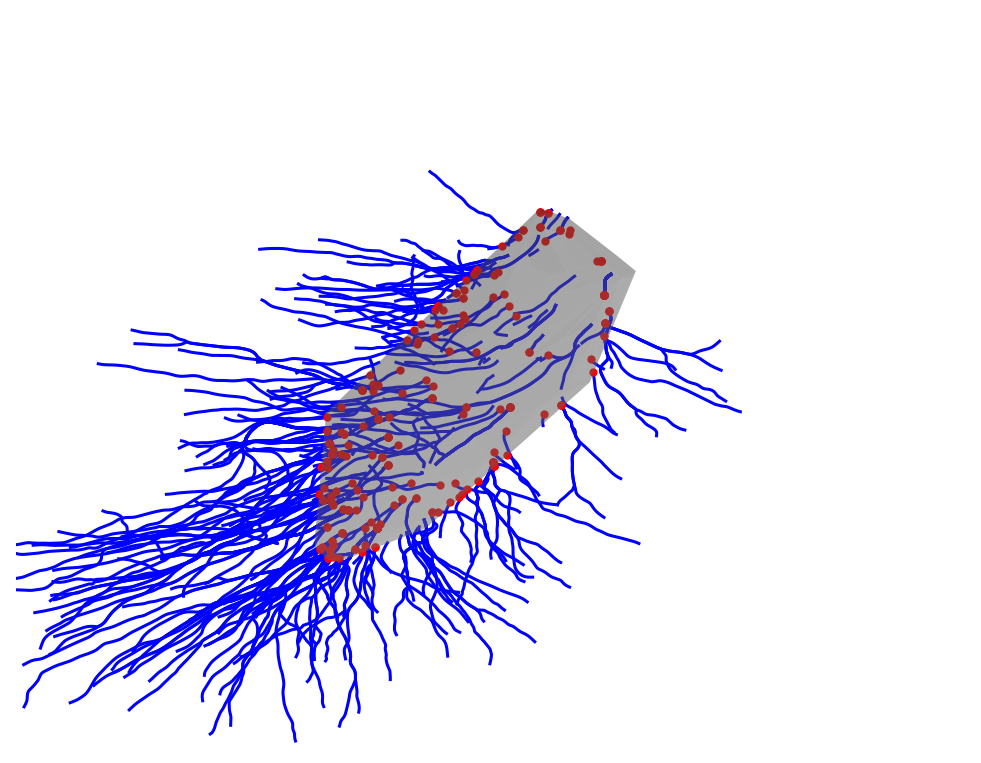

In [45]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111,projection="3d")

filament_id = 0

rootid_lst = foli6.get_root()
for i in range(len(rootid_lst)):
    rootid = rootid_lst[i]
    
    # extract filament from rootid
    filament = foli6.extract_subtrees(nodeid=rootid,rootid=rootid)
    
#     foli4.plot(ax,rootid=rootid,projection="3d",
#                show_root=True,root_args={"s":25},
#                show_branchingnodes=False,show_leaves=False)
    
    # checking intersection
    for nodes in filament.decompose_leaves().values():
        
        length, tortuosity, lstmp = 0,[],[]
        xtheta, ytheta, ztheta = [],[],[]
        f1theta, f2theta = [], []
        
        # convert to Curve
        crv = filament.to_curve(nodes)
        intersect_pnts, _ = curvesurface.intersect(crv,trunk6)
        if intersect_pnts is not None:
            # intersected points
            xint, yint, zint = intersect_pnts.coors[0,0],intersect_pnts.coors[0,1],intersect_pnts.coors[0,2]
            ax.scatter(xint,yint,zint,color="red")
            
            # getting section from outside of the trunk
            _, _, outside_sections = curvesurface.inonout(crv,trunk6)
            if len(outside_sections)!=0:
                for s in outside_sections:
                    s.plot(ax, projection="3d", show_root=False, line_args={'c':'blue','lw':2})
                    
                    length += s.compute_length()
                    
                    tortuosity.append(s.compute_tortuosity())
                    
                    lstmp.append(np.mean(s.compute_local_3d_scale(np.arange(1,radius+1,1))))
                    
                    _, thetas = s.compute_orientation()
                    xtheta += list(thetas[:,0])
                    ytheta += list(thetas[:,1])
                    ztheta += list(thetas[:,2])
                    
                    _, tmp = s.compute_orientation(u=np.array([v6[0,0],v6[0,1],0])) # angle with the first pca
                    f1theta += list(tmp)
                    
                    _, tmp = s.compute_orientation(u=np.array([v6[1,0],v6[1,1],0])) # angle with the second pca
                    f2theta += list(tmp)  
                    
        if((length!=0) & (len(tortuosity)!=0) & (len(lstmp)!=0)):
            xints.append(xint)
            yints.append(yint)
            zints.append(zint)
            lengths.append(length)
            tortuosities.append(np.mean(tortuosity))
            ls.append(np.mean(lstmp))
            xthetas.append(np.mean(xtheta)*180/np.pi)
            ythetas.append(np.mean(ytheta)*180/np.pi)
            zthetas.append(np.mean(ztheta)*180/np.pi)
            f1thetas.append(np.mean(f1theta)*180/np.pi)
            f2thetas.append(np.mean(f2theta)*180/np.pi)
            folliums.append("DIV6")
            filaments.append(filament_id)
            filament_id += 1
                    
trunk6.plot(ax,projection="3d",args_3d={"edgecolor":None,"alpha":0.3,"color":"gray"})
ax.view_init(azim=-128,elev=52)
ax.axis("off");
plt.tight_layout();

In [18]:
fig.savefig("output/div6-intersection.png",dpi=400)

# Build dataframe

In [46]:
df = pd.DataFrame({"Follium":folliums,"Filaments":filaments,
                   "Xint":xints,"Yint":yints,"Zint":zints,
                   "Xtheta":xthetas,"Ytheta":ythetas,"Ztheta":zthetas,
                   "F1theta":f1thetas,"F2theta":f2thetas,
                   "Length":lengths,"Tortuosity":tortuosities,"Localscale":ls})

In [47]:
df

,Follium,Filaments,Xint,Yint,Zint,Xtheta,Ytheta,Ztheta,F1theta,F2theta,Length,Tortuosity,Localscale
0,DIV4,0,430.465240,447.586555,0.500003,31.184014,115.071560,87.141276,41.160541,52.096534,128.107421,1.052240,15.250000
1,DIV4,1,430.465240,447.586555,0.500003,40.093138,129.419225,88.186383,26.882396,65.870279,122.082256,1.012144,15.045455
2,DIV4,2,430.465240,447.586555,0.500003,30.287044,118.103621,84.795234,38.352167,54.892582,103.733186,1.019686,20.956897
3,DIV4,3,390.250767,404.129224,37.068116,33.382817,113.080171,70.025302,45.729176,54.897880,38.672471,1.028899,30.826087
4,DIV4,4,350.664544,340.995682,55.500011,105.961250,151.517441,98.441147,43.688462,131.230892,101.059163,1.123971,29.156250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,DIV6,275,607.941699,471.087529,58.725787,141.989782,60.160261,98.154405,59.331621,37.268019,47.149356,1.125543,16.797619
470,DIV6,276,586.930520,460.068610,60.212986,144.237394,54.478571,91.077508,60.802529,29.132899,30.068123,1.017477,29.000000
471,DIV6,277,494.108010,428.370497,60.500065,155.820453,67.960999,94.968852,48.226589,43.018475,147.520755,1.035432,20.428571
472,DIV6,278,585.177654,436.174565,62.864164,141.744467,55.089192,89.371168,61.695860,31.129853,227.495926,1.054482,34.763158


In [48]:
df.to_csv("output/df.csv")